# <a name="contents">Содержание</a>
## [1. Ознакомление c данными](#stage_1)
   

## [2. Решение поставленных задач](#stage_2)


## [3. Выводы](#stage_3)

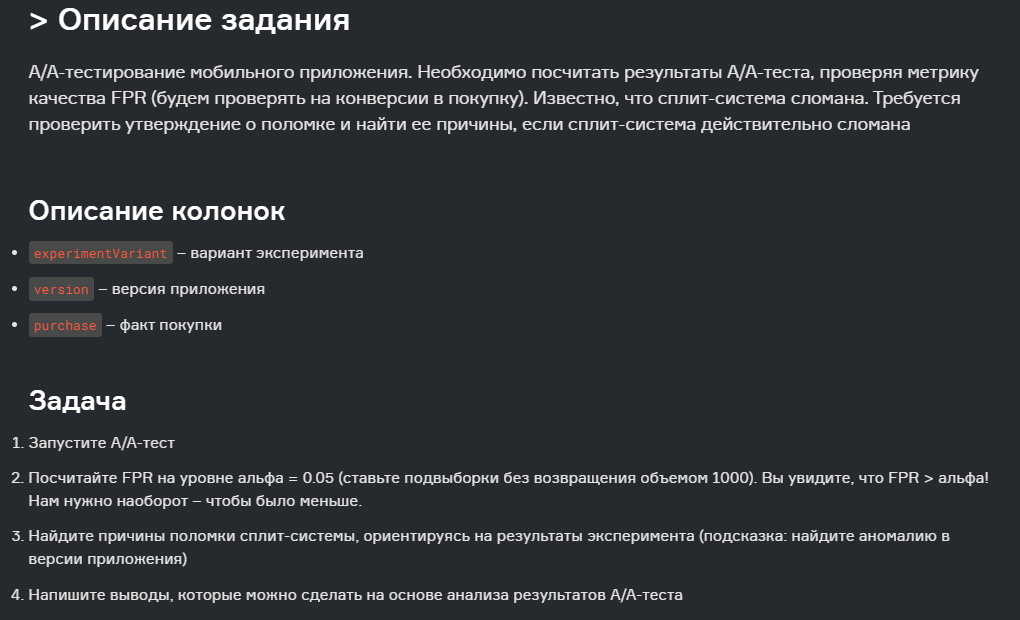

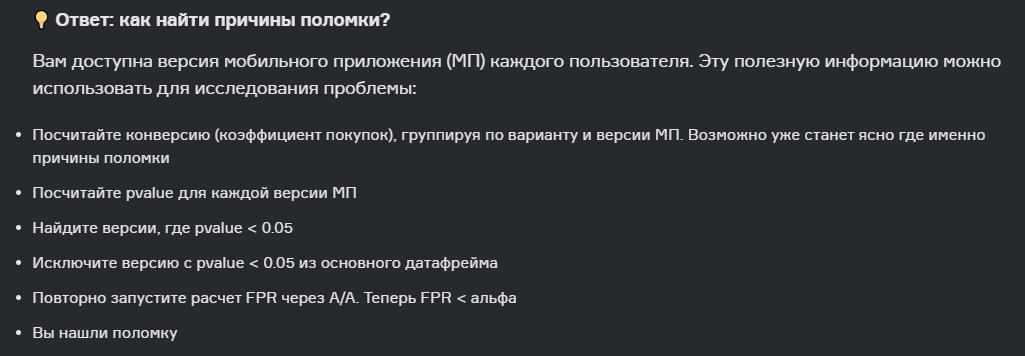

<a name="stage_1"></a>
# 1. Ознакомление с данными


[Наверх к оглавлению](#contents)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st

from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep=';', index_col=[0])
df

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...
127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


In [3]:
df.nunique()

uid                  127018
experimentVariant         2
version                   4
purchase                  2
dtype: int64

In [4]:
df.experimentVariant.value_counts()

1    63916
0    63102
Name: experimentVariant, dtype: int64

<a name="stage_2"></a>
# 2. Решение поставленных задач


[Наверх к оглавлению](#contents)

### Запускаем А-А тест

In [5]:
# многократно извлекаем синтетические выборки и сравниваем их
res = []
n_s = 1000
simulations = 1000

for i in tqdm(range(simulations)):
    s1 = df[df['experimentVariant'] == 0]['purchase'].sample(n_s, replace = False).values
    s2 = df[df['experimentVariant'] == 1]['purchase'].sample(n_s, replace = False).values
    res.append(st.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Alex\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


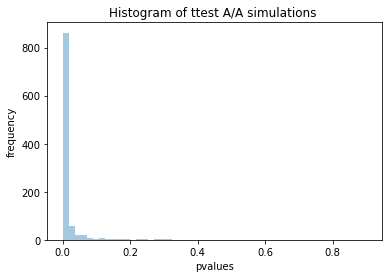

In [6]:
# смотрим на распределение p value
sns.distplot(res, kde=False, bins=50)
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

### Посчитаем FPR

In [7]:
# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

0.934

In [8]:
# Вывод:
# Система сплитования действительно работает неправильно

### Найдем причину поломки сплит-системы

In [9]:
df.groupby(['experimentVariant', 'version'], as_index=False) \
    .uid \
    .count() \
    .pivot(index='experimentVariant', columns='version')

uid                         
version           v2.8.0 v2.9.0 v3.7.4.0 v3.8.0.0
experimentVariant                                
0                  41283  11921     4204     5694
1                  41552  12033     4221     6110

In [10]:
df.groupby(['experimentVariant', 'version'], as_index=False) \
    .purchase \
    .sum() \
    .pivot(index='experimentVariant', columns='version')

purchase                         
version             v2.8.0 v2.9.0 v3.7.4.0 v3.8.0.0
experimentVariant                                  
0                       41    890      252      328
1                     1895    858      266      384

In [11]:
# по всей видимости проблема в сплитовании по версии приложения v2.8.0.

# возможно проблема также могла возникнуть в сплитовании по версии v3.8.0.0,
# т.к. в группе 1 количество человек на 10% больше, а конверсия на 20% меньше

# Проверим это с помощью А/А теста

In [12]:
# многократно извлекаем синтетические выборки и сравниваем их
res = []
n_s = 1000
simulations = 1000

for i in tqdm(range(simulations)):
    s1 = df[(df['experimentVariant'] == 0) & (df['version'] != 'v2.8.0')] \
        ['purchase'].sample(n_s, replace = False).values
    s2 = df[(df['experimentVariant'] == 1) & (df['version'] != 'v2.8.0')] \
        ['purchase'].sample(n_s, replace = False).values
    res.append(st.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Alex\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


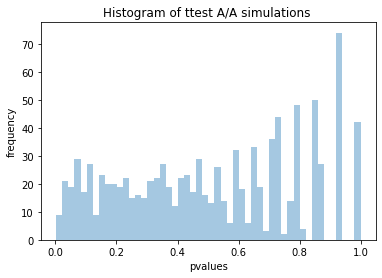

In [13]:
# смотрим на распределение p value
sns.distplot(res, kde=False, bins=50)
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

In [14]:
# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

0.036

In [15]:
# многократно извлекаем синтетические выборки и сравниваем их
res = []
n_s = 1000
simulations = 1000

for i in tqdm(range(simulations)):
    s1 = df[(df['experimentVariant'] == 0) & (df['version'] != 'v2.8.0') & (df['version'] != 'v3.8.0.0')] \
        ['purchase'].sample(n_s, replace = False).values
    s2 = df[(df['experimentVariant'] == 1) & (df['version'] != 'v2.8.0') & (df['version'] != 'v3.8.0.0')] \
        ['purchase'].sample(n_s, replace = False).values
    res.append(st.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

  0%|          | 0/1000 [00:00<?, ?it/s]

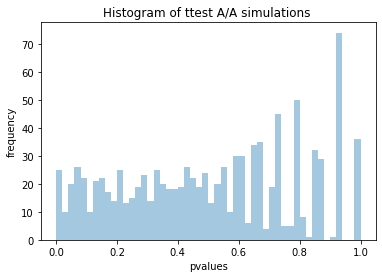

In [16]:
# смотрим на распределение p value
sns.distplot(res, kde=False, bins=50)
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

In [17]:
# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

0.042

In [18]:
# так как разница FPR при включении версии приложения v3.8.0.0 была не столь существенна,
# проведем отдельно А/А тест для этой версии приложения

  0%|          | 0/1000 [00:00<?, ?it/s]

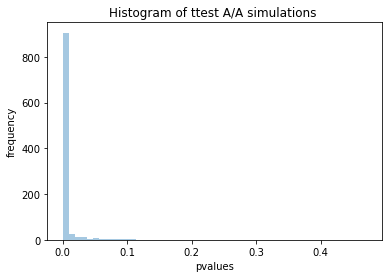

0.965

In [19]:
# многократно извлекаем синтетические выборки и сравниваем их
res = []
n_s = 1000
simulations = 1000

for i in tqdm(range(simulations)):
    s1 = df[(df['experimentVariant'] == 0) & (df['version'] != 'v3.8.0.0')] \
        ['purchase'].sample(n_s, replace = False).values
    s2 = df[(df['experimentVariant'] == 1) & (df['version'] != 'v3.8.0.0')] \
        ['purchase'].sample(n_s, replace = False).values
    res.append(st.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

# смотрим на распределение p value
sns.distplot(res, kde=False, bins=50)
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

<a name="stage_3"></a>
# 3. Выводы


[Наверх к оглавлению](#contents)

Мы провели А/А тест мобильного приложения и убедились, что сплит-система действительно работает некорректно (FPR > a). Проведя дополнительно несколько А/А тестов, мы обнаружили проблемы в сплитовании по версиям приложения v3.8.0.0 и v2.8.0.